# Backtesting volatility

Many models (especially in portfolio optimisation) assume that historical volatility is a good estimator of future volatility. In this study, we examine the degree to which volatility can be forecasted. 

## Methodology

For the S&P500, we will collect as much data as possible, then form 1y, 3y, 5y, 10y, 20y rolling windows. From these, we will conduct a regression to understand how well historical volatility predicts the realised annual volatility in the subsequent year.

This could easily be extended to examine the predictivity of past covariance and future covariance, though in this case we would have to decide on a metric for the "distance" between two covariance matrices.

## Part 1 - S&P500 Data

In [16]:
import datetime
import pandas as pd
from pandas_datareader import data as web
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
plt.rcParams["figure.figsize"] = (20,10)

In [18]:
# Acquire raw S&P500 data

# sp500_df = web.DataReader("^GSPC", "yahoo", 
#                           datetime.datetime(1950,1,1), 
#                           datetime.datetime(2019,12,19))
# sp500_df.to_csv("data/sp500_prices.csv")
sp500_df = pd.read_csv("data/sp500_prices.csv", parse_dates=True)
sp500_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,1950-01-03,16.66,16.66,16.66,16.66,1260000,16.66
1,1950-01-04,16.85,16.85,16.85,16.85,1890000,16.85
2,1950-01-05,16.93,16.93,16.93,16.93,2550000,16.93
3,1950-01-06,16.98,16.98,16.98,16.98,2010000,16.98
4,1950-01-09,17.08,17.08,17.08,17.08,2520000,17.08


In [19]:
px = sp500_df.set_index("Date")["Adj Close"]

In [20]:
rets = px.pct_change().dropna()
rets.head()

Date
1950-01-04    0.011405
1950-01-05    0.004748
1950-01-06    0.002953
1950-01-09    0.005889
1950-01-10   -0.002927
Name: Adj Close, dtype: float64

In [21]:
n_days = 252  # trading days in a year
time_periods = [1, 3, 5, 10, 20]  # in years
stds = []
for t in time_periods:
    stds.append(rets.rolling(t * n_days).std())
std_df = pd.concat(stds, axis=1)
std_df.columns = [f"{t}y" for t in time_periods]
std_df *= np.sqrt(252)  # annualise
std_df.tail()

,1y,3y,5y,10y,20y
Date,,,,,
2019-12-13,0.143483,0.128009,0.135261,0.147725,0.188674
2019-12-16,0.142234,0.128019,0.135090,0.147731,0.188642
2019-12-17,0.140569,0.127923,0.135056,0.147727,0.188635
2019-12-18,0.140573,0.127909,0.134998,0.147713,0.188622
2019-12-19,0.139656,0.127923,0.134715,0.147706,0.188622


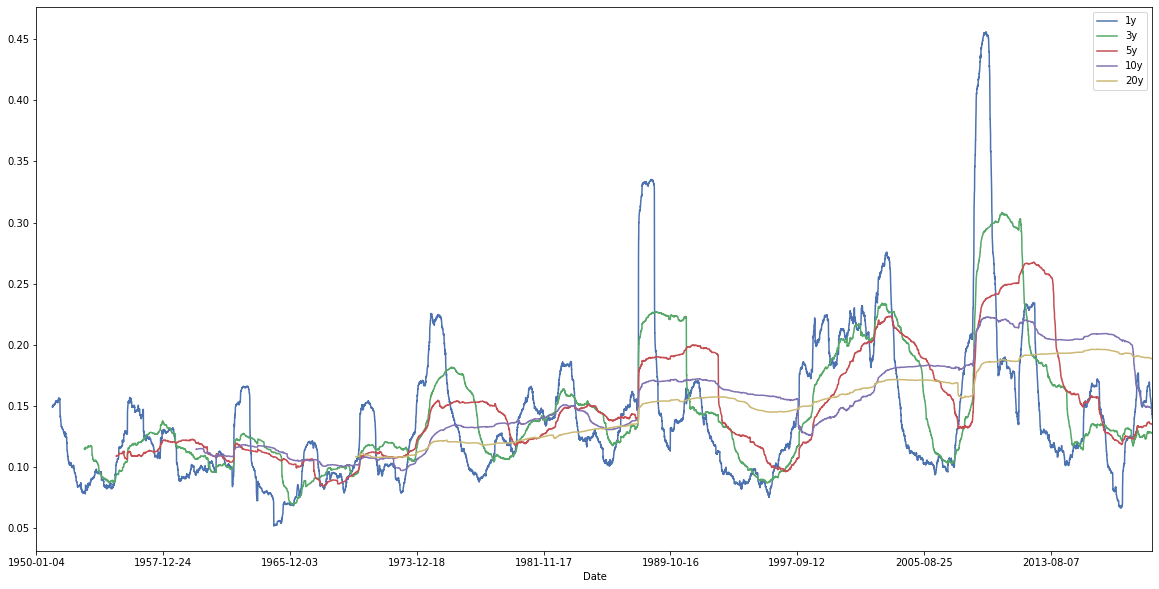

In [22]:
std_df.plot()
# plt.savefig("std_plot.png", dpi=400)

As expected, longer time periods result in smoother curves (since more data is used, so the aggregration is more stable).

In [23]:
# Compute realised annual volatilities
realised_vol = rets.rolling(n_days).std().shift(-n_days) * np.sqrt(252)
realised_vol = realised_vol.rename("realised_vol")
realised_vol.head()

Date
1950-01-04    0.148951
1950-01-05    0.148979
1950-01-06    0.149594
1950-01-09    0.150306
1950-01-10    0.150330
Name: realised_vol, dtype: float64

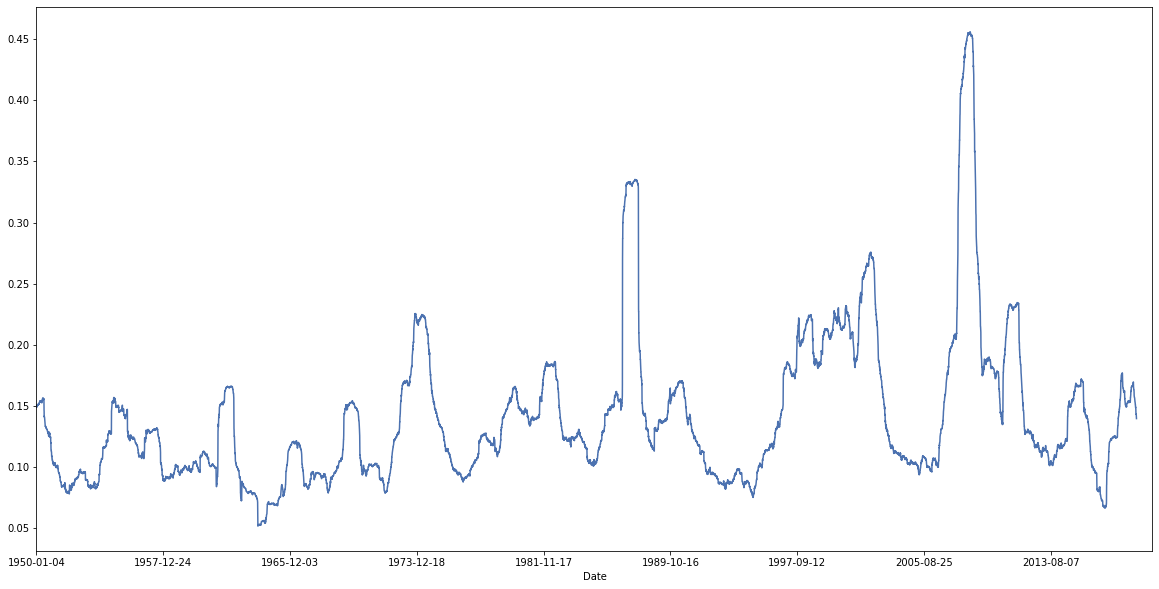

In [24]:
realised_vol.plot()

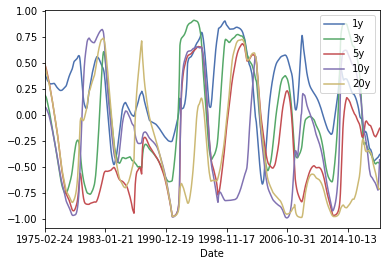

In [10]:
# use a 5y agg period for rolling correlation
corr = realised_vol.rolling(n_days*5).corr(std_df).dropna()
corr.plot()
# plt.savefig("corrplot.png", dpi=400)

In [15]:
# compute mean correlation coefficients
std_df.corrwith(realised_vol)

1y     0.429631
3y     0.286037
5y     0.176046
10y    0.179328
20y    0.058464
dtype: float64

In [12]:
mae = np.abs(std_df.subtract(realised_vol, axis=0)).mean()
mae

1y     0.043003
3y     0.048608
5y     0.050167
10y    0.050909
20y    0.049677
dtype: float64

In [24]:
rmse = np.sqrt(((std_df.subtract(realised_vol, axis=0))**2).mean())
rmse

1y     0.065383
3y     0.067677
5y     0.069621
10y    0.067687
20y    0.069352
dtype: float64

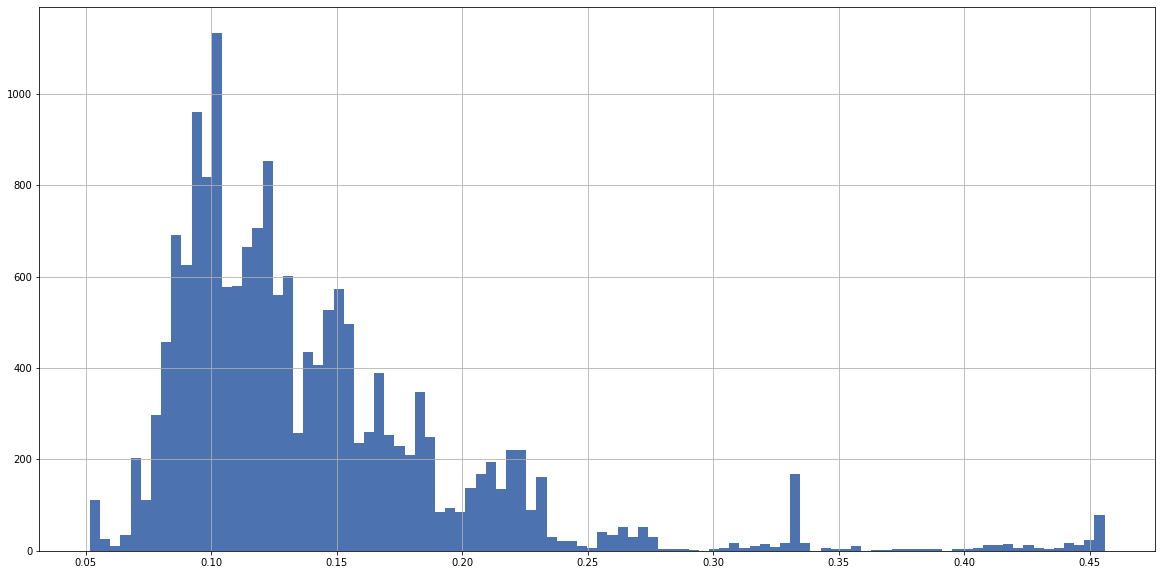

In [26]:
realised_vol.hist(bins=100)
# plt.savefig("realised_vol_hist.png", dpi=400)

## Distribution of prediction errors

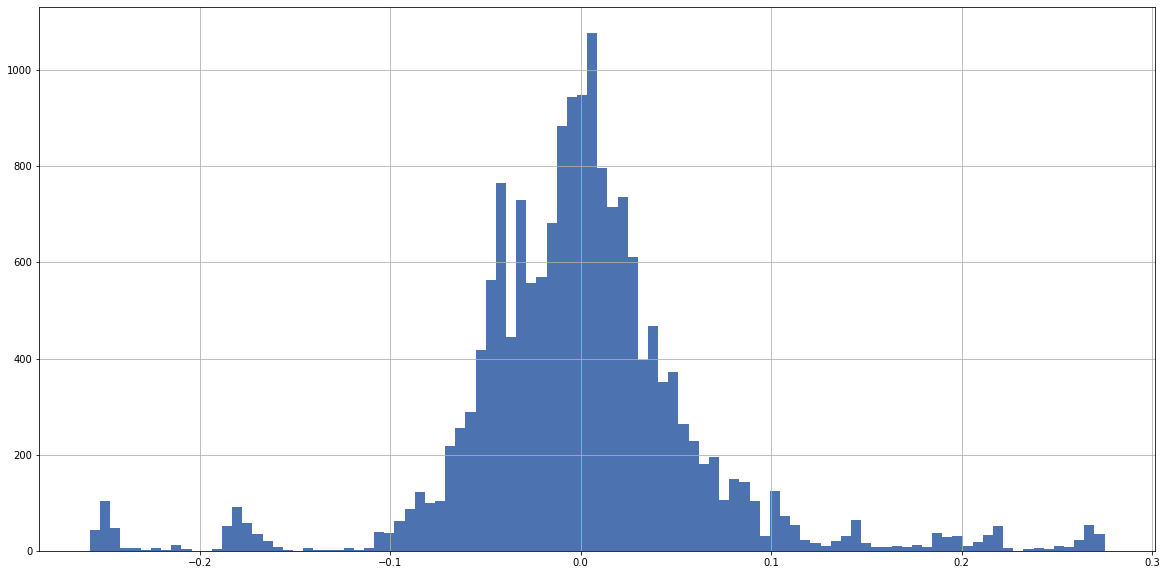

In [30]:
(std_df["1y"] - realised_vol).hist(bins=100)
plt.savefig("vol_errors_hist.png", dpi=400)

In [29]:
(std_df.subtract(realised_vol, axis=0)).mean()

1y    -0.000291
3y     0.003323
5y     0.005505
10y    0.007082
20y   -0.002426
dtype: float64